## Process of analysing each PCAP file
1. Load the PCAP file 
2. Convert it to JSON
3. Extract dns packets
4. Try to find IPs for which we don't have their endpoint names
5. Create a dictionary of {"fqdn": {"domain_name:"", "subdomain":"", "organization":"", "ATSes":"", "Party":""}}
6. Find organizations
    6.1 using DDG's emtity list
    6.2 mannualy look at WHOIS and crunchbaxe.com
7. Find ATSes
8. Find Parties
9. Create large dataframe for each packet

In [1]:
import utilities
from subprocess import call
from subprocess import check_call
import os, sys
import tldextract
import pandas as pd

## 1. load traffic

In [2]:
base_out = "/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/post_processing/single_pcaps"
pcap = os.path.join(base_out, "data/spotify.pcap")

## 2. convert pcap to json

In [3]:
jsonFile = pcap + "-ENC-out.json"

In [4]:
cmd = ["tshark",
           "-o", "tcp.analyze_sequence_numbers:TRUE",
           "-o", "tcp.desegment_tcp_streams:TRUE",
           "-o", "http.desegment_body:TRUE",
           "-r", pcap, "-T", "json"]

with open(jsonFile, "wb") as jf:
    check_call(cmd, stdout=jf)

## 3. DNS Resolutions

In [5]:
dns_resolutions = {}
pcap_name = pcap.split('/')[-1].split('.')[0]


network_json_dir = os.path.join(base_out,"data" ,pcap_name+".pcap-ENC-out.json")
network_json = utilities.read_json(network_json_dir)

for i in range(len(network_json)):
    if network_json[i]["_source"]["layers"]["frame"]["frame.protocols"] == 'eth:ethertype:ip:udp:dns':
        answers_key = []
        if "Answers" in network_json[i]["_source"]["layers"]["dns"].keys():
            answers_key  = network_json[i]["_source"]["layers"]["dns"]["Answers"].keys()
            for key in answers_key:
                if "CNAME" in key:
                    #print("CNAME")
                    continue
                try:    
                    dns_a = network_json[i]["_source"]["layers"]["dns"]["Answers"][key]["dns.a"]
                    dns_name = network_json[i]["_source"]["layers"]["dns"]["Answers"][key]["dns.resp.name"]
                    dns_resolutions[dns_a] = dns_name
                except:
                    pass

In [6]:
dns_resolutions

{'54.161.64.53': 'fireoscaptiveportal.com',
 '54.197.100.100': 'fireoscaptiveportal.com',
 '18.215.2.115': 'fireoscaptiveportal.com',
 '18.232.191.54': 'fireoscaptiveportal.com',
 '54.204.135.149': 'fireoscaptiveportal.com',
 '34.232.151.33': 'fireoscaptiveportal.com',
 '34.200.157.175': 'fireoscaptiveportal.com',
 '54.88.240.89': 'fireoscaptiveportal.com',
 '108.138.242.27': 'd1gsg05rq1vjdw.cloudfront.net',
 '44.193.242.252': 'acsechocaptiveportal.com',
 '52.203.105.214': 'acsechocaptiveportal.com',
 '34.235.29.94': 'acsechocaptiveportal.com',
 '3.215.62.147': 'acsechocaptiveportal.com',
 '54.86.95.199': 'acsechocaptiveportal.com',
 '52.207.128.183': 'acsechocaptiveportal.com',
 '52.94.237.71': 'dss-na.amazon.com',
 '108.139.1.121': 'ffs-provisioner-config.amazon-dss.com',
 '108.139.1.55': 'ffs-provisioner-config.amazon-dss.com',
 '108.139.1.83': 'ffs-provisioner-config.amazon-dss.com',
 '108.139.1.124': 'ffs-provisioner-config.amazon-dss.com',
 '209.54.180.44': 'api.amazon.com',
 '72

## 4. Find IPs for which dns map doesn't have corresponding name

In [7]:
no_name_ip_list = set()
for i in range(len(network_json)):
        if 'ip' in network_json[i]["_source"]["layers"].keys():
            ip_src = network_json[i]["_source"]["layers"]['ip']['ip.src']
            ip_dst = network_json[i]["_source"]["layers"]['ip']['ip.dst']
            
            if not ip_src.startswith('10.42') and not ip_src.startswith('255.255.'):
                if ip_src not in dns_resolutions:
                    no_name_ip_list.add(ip_src)
            
            if not ip_dst.startswith('10.42') and not ip_dst.startswith('255.255.'):
                if ip_dst not in dns_resolutions:
                    no_name_ip_list.add(ip_dst)
no_name_ip_list

{'0.0.0.0',
 '224.0.0.22',
 '224.0.0.251',
 '239.255.255.250',
 '52.94.243.11',
 '8.8.8.8'}

In [8]:
dns_resolutions['52.94.243.11'] = "dss-na.amazon.com"
utilities.write_json(os.path.join(base_out, "dns_resolutions.json"), dns_resolutions)

## 5. Creat a dictionary for fqdns in dns 

In [9]:
dict_fqdns = {}
for ip, fqdn in dns_resolutions.items():
    if fqdn not in dict_fqdns:
        dict_fqdns[fqdn] = {'domain_name': '', 'SLD': '', 'subdomain' : '' ,'organization': '', 'ATSes': '', 'Party': ''}
        ext = tldextract.extract(fqdn)
        dict_fqdns[fqdn]['domain_name'] = ext.domain+"."+ext.suffix
        dict_fqdns[fqdn]['subdomain'] = ext.subdomain
        dict_fqdns[fqdn]['SLD'] = ext.domain
        dict_fqdns[fqdn]['organization'] = ""
        dict_fqdns[fqdn]['ATSes'] = ""
        dict_fqdns[fqdn]['Party'] = ""
dict_fqdns

{'fireoscaptiveportal.com': {'domain_name': 'fireoscaptiveportal.com',
  'SLD': 'fireoscaptiveportal',
  'subdomain': '',
  'organization': '',
  'ATSes': '',
  'Party': ''},
 'd1gsg05rq1vjdw.cloudfront.net': {'domain_name': 'cloudfront.net',
  'SLD': 'cloudfront',
  'subdomain': 'd1gsg05rq1vjdw',
  'organization': '',
  'ATSes': '',
  'Party': ''},
 'acsechocaptiveportal.com': {'domain_name': 'acsechocaptiveportal.com',
  'SLD': 'acsechocaptiveportal',
  'subdomain': '',
  'organization': '',
  'ATSes': '',
  'Party': ''},
 'dss-na.amazon.com': {'domain_name': 'amazon.com',
  'SLD': 'amazon',
  'subdomain': 'dss-na',
  'organization': '',
  'ATSes': '',
  'Party': ''},
 'ffs-provisioner-config.amazon-dss.com': {'domain_name': 'amazon-dss.com',
  'SLD': 'amazon-dss',
  'subdomain': 'ffs-provisioner-config',
  'organization': '',
  'ATSes': '',
  'Party': ''},
 'api.amazon.com': {'domain_name': 'amazon.com',
  'SLD': 'amazon',
  'subdomain': 'api',
  'organization': '',
  'ATSes': '',
 

## 6. Find Organizations

In [13]:
ddg_entities = utilities.get_files_in_a_directory("/home/c2/alexa/post-processing/tracker-radar/entities")

for fqdn, details in dict_fqdns.items():
    for entity in ddg_entities:
        entity_content = utilities.read_json(entity)
        if details['domain_name'] in entity_content["properties"]:
            dict_fqdns[fqdn]['organization'] = entity_content["name"]
            break

In [14]:
not_found_organizations = set()
for fqdn, details in dict_fqdns.items():
    if len(details['organization']) == 0:
        not_found_organizations.add(details['domain_name'])

In [15]:
not_found_organizations

{'acsechocaptiveportal.com',
 'amazon-dss.com',
 'amcs-tachyon.com',
 'fireoscaptiveportal.com'}

### For organizations we didn't find on DDG, we use https://lookup.icann.org/lookup and crunchbase.com

In [16]:
manually_found_organs = {'acsechocaptiveportal.com' : 'Amazon Technologies, Inc.',
 'amazon-dss.com' : 'Amazon Technologies, Inc.',
 'amcs-tachyon.com' : 'Amazon Technologies, Inc.',
 'fireoscaptiveportal.com' : 'Amazon Technologies, Inc.'}

In [17]:
for fqdn, details in dict_fqdns.items():
    if len(details['organization']) == 0:
        details['organization'] = manually_found_organs[details['domain_name']]
    

In [18]:
for index, row in df.iterrows():
    if len(row['organization']) == 0:
        print(row['domain_name'])
        

NameError: name 'df' is not defined

## 7. Find ATSes

In [19]:
filter_list_base = "/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/filter_lists/"
tracking = utilities.read_json(os.path.join(filter_list_base,"tracking", "tracking_list.json"))
advertising = utilities.read_json(os.path.join(filter_list_base, "advertising", "advertising_list.json"))

In [21]:
for fqdn, details in dict_fqdns.items():
    if fqdn in tracking or fqdn in advertising:
        details['ATSes'] = "ATSes"
        print(fqdn)
    else:
        details['ATSes'] = "others"

fireoscaptiveportal.com
device-metrics-us-2.amazon.com


## 8. Find Parties

In [28]:
for fqdn, details in dict_fqdns.items():
    try:
        if details['organization'] == 'Amazon Technologies, Inc.':
            details['Party'] = "Platform-based"
            continue
        if details['organization'] == 'Spotify AB':
            details['Party'] = "First-Party"
            continue
        else:
            details['Party'] = "Third-Party"
    except:
        print(fqdn)

In [29]:
dict_fqdns

{'fireoscaptiveportal.com': {'domain_name': 'fireoscaptiveportal.com',
  'SLD': 'fireoscaptiveportal',
  'subdomain': '',
  'organization': 'Amazon Technologies, Inc.',
  'ATSes': 'ATSes',
  'Party': 'Platform-based'},
 'd1gsg05rq1vjdw.cloudfront.net': {'domain_name': 'cloudfront.net',
  'SLD': 'cloudfront',
  'subdomain': 'd1gsg05rq1vjdw',
  'organization': 'Amazon Technologies, Inc.',
  'ATSes': 'others',
  'Party': 'Platform-based'},
 'acsechocaptiveportal.com': {'domain_name': 'acsechocaptiveportal.com',
  'SLD': 'acsechocaptiveportal',
  'subdomain': '',
  'organization': 'Amazon Technologies, Inc.',
  'ATSes': 'others',
  'Party': 'Platform-based'},
 'dss-na.amazon.com': {'domain_name': 'amazon.com',
  'SLD': 'amazon',
  'subdomain': 'dss-na',
  'organization': 'Amazon Technologies, Inc.',
  'ATSes': 'others',
  'Party': 'Platform-based'},
 'ffs-provisioner-config.amazon-dss.com': {'domain_name': 'amazon-dss.com',
  'SLD': 'amazon-dss',
  'subdomain': 'ffs-provisioner-config',
  

## 9. Edit Final DataFrame

In [30]:
main_df = {'fqdn': [], 'domain_name': [], 'SLD': [], 'subdomain' : [] ,'organization': [], 'ATSes': [], 'Party': []}


for i in range(len(network_json)):
    if 'ip' in network_json[i]["_source"]["layers"].keys():
        ip_dst =   network_json[i]["_source"]["layers"]['ip']['ip.dst']
        if not ip_dst.startswith("10.42.") and not ip_dst.startswith("255.255.") and not ip_dst.startswith("8.8.") and not ip_dst.startswith("0.0.") and not ip_dst.startswith("224.0") and not ip_dst.startswith("239.255"):
            fqdn = dns_resolutions[ip_dst]
            main_df['fqdn'].append(fqdn)
            main_df['domain_name'].append(dict_fqdns[fqdn]['domain_name'])
            main_df['subdomain'].append(dict_fqdns[fqdn]['subdomain'])         
            main_df['SLD'].append(dict_fqdns[fqdn]['SLD'])
            main_df['organization'].append(dict_fqdns[fqdn]['organization'])
            main_df['ATSes'].append(dict_fqdns[fqdn]['ATSes'])
            main_df['Party'].append(dict_fqdns[fqdn]['Party'])

In [31]:
df = pd.DataFrame.from_dict(main_df)
df.to_csv(os.path.join(base_out,"report.csv"), sep=',')
df

,fqdn,domain_name,SLD,subdomain,organization,ATSes,Party
0,d1gsg05rq1vjdw.cloudfront.net,cloudfront.net,cloudfront,d1gsg05rq1vjdw,"Amazon Technologies, Inc.",others,Platform-based
1,acsechocaptiveportal.com,acsechocaptiveportal.com,acsechocaptiveportal,,"Amazon Technologies, Inc.",others,Platform-based
2,fireoscaptiveportal.com,fireoscaptiveportal.com,fireoscaptiveportal,,"Amazon Technologies, Inc.",ATSes,Platform-based
3,ffs-provisioner-config.amazon-dss.com,amazon-dss.com,amazon-dss,ffs-provisioner-config,"Amazon Technologies, Inc.",others,Platform-based
4,d1gsg05rq1vjdw.cloudfront.net,cloudfront.net,cloudfront,d1gsg05rq1vjdw,"Amazon Technologies, Inc.",others,Platform-based
...,...,...,...,...,...,...,...
51571,mlis.amazon.com,amazon.com,amazon,mlis,"Amazon Technologies, Inc.",others,Platform-based
51572,mlis.amazon.com,amazon.com,amazon,mlis,"Amazon Technologies, Inc.",others,Platform-based
51573,mlis.amazon.com,amazon.com,amazon,mlis,"Amazon Technologies, Inc.",others,Platform-based
51574,mlis.amazon.com,amazon.com,amazon,mlis,"Amazon Technologies, Inc.",others,Platform-based


# Visualization

### 1. Plot Taxonomy

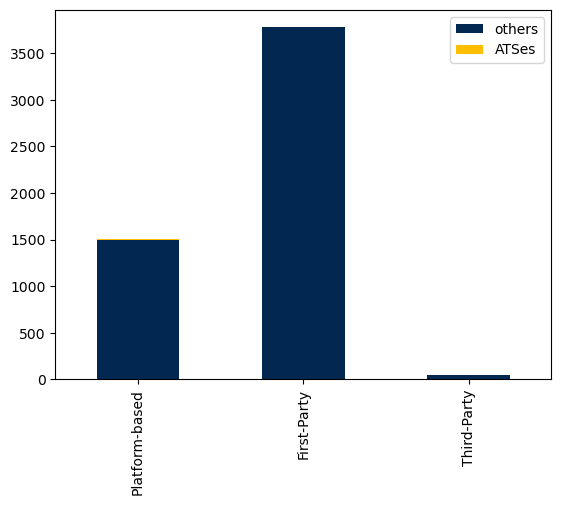

In [32]:
other = [1501, 3778, 49]

ATSes = [7, 0, 0]

index = ['Platform-based', 'First-Party', 'Third-Party']

df_taxonomy = pd.DataFrame({'others': other, 'ATSes': ATSes}, index=index)

ax = df_taxonomy.plot.bar(stacked=True, color={"others": "#022851", "ATSes": "#FFBF00"})

### 2. Platfom-based FQDNs

In [33]:
df_fqdn = df.loc[df['Party'] == 'Platform-based', 'fqdn']
platform_base = {}
for fqdn in df_fqdn:
    if fqdn not in platform_base:
        platform_base[fqdn] = 1
    else:
        platform_base[fqdn] += 1
fqdn_skill_num_sorted = dict(sorted(platform_base.items(), key=lambda kv: kv[1], reverse=True))

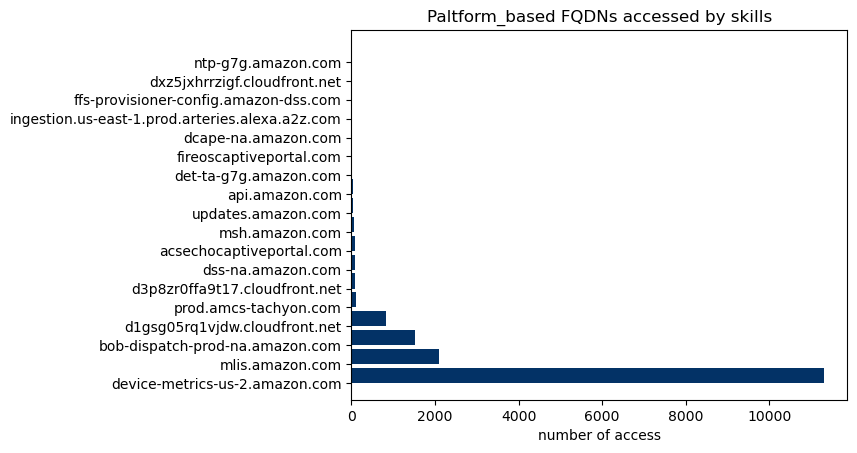

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
fqdns = [fqdn for fqdn, skills_nums in fqdn_skill_num_sorted.items()]
y_pos = np.arange(0,len(fqdn_skill_num_sorted),1)
performance = [skills_nums for fqdn, skills_nums in fqdn_skill_num_sorted.items()]
#error = np.random.rand(len(fqdns))

ax.barh(y_pos, performance, align='edge', color = '#033266')
ax.set_yticks(y_pos)
ax.set_yticklabels(fqdns)
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('number of access')
ax.set_title('Paltform_based FQDNs accessed by skills')
plt.savefig('platform_barchart.png')
plt.show()

In [35]:
df_fqdn_non = df.loc[(df['Party'] == 'Third-Party') | (df['Party'] == 'First-Party'), 'fqdn']
non_platform_base = {}
for fqdn in df_fqdn_non:
    if fqdn not in non_platform_base:
        non_platform_base[fqdn] = 1
    else:
        non_platform_base[fqdn] += 1
fqdn_skill_num_sorted_non = dict(sorted(non_platform_base.items(), key=lambda kv: kv[1], reverse=True))

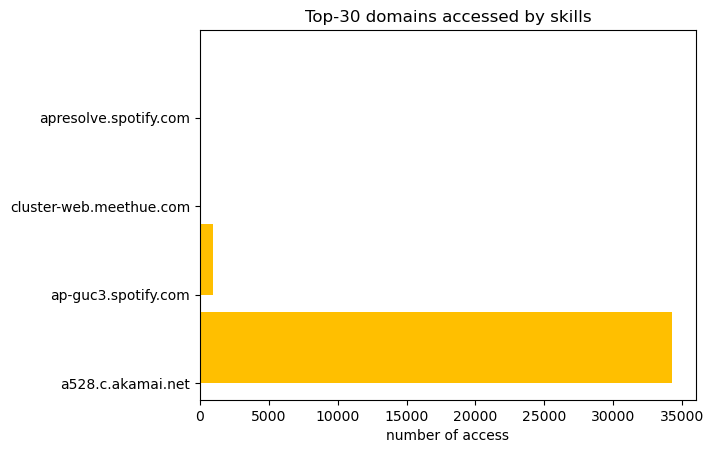

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
fqdns = [fqdn for fqdn, skills_nums in fqdn_skill_num_sorted_non.items()]
y_pos = np.arange(0,len(fqdn_skill_num_sorted_non),1)
performance = [skills_nums for fqdn, skills_nums in fqdn_skill_num_sorted_non.items()]
#error = np.random.rand(len(fqdns))

ax.barh(y_pos, performance, align='edge', color='#FFBF00')
ax.set_yticks(y_pos)
ax.set_yticklabels(fqdns)
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('number of access')
ax.set_title('Top-30 domains accessed by skills')
plt.savefig('thirdparty_barchart.png')
plt.show()